<a href="https://colab.research.google.com/github/anshupandey/MSA-analytics/blob/main/POTMS2/Lab4_Ocean_Hull_Insurance_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚙️ Optimization Exercises on Ocean Hull Insurance Portfolio

This notebook explores:
- **Exercise 1**: Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
- **Exercise 2**: Portfolio Simulation and Return Projection
- **Exercise 3**: Mean-Variance Optimization

We use the previously generated Ocean Hull Insurance dataset to perform experimental risk analysis.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## 📥 Load and Explore Dataset

In [4]:
# Replace with actual path if needed
df = pd.read_csv('https://raw.githubusercontent.com/anshupandey/MSA-analytics/refs/heads/main/datasets/Ocean_Hull_Insurance_datasetv2.csv')
df.head()

,Vessel_ID,Vessel_Type,Operating_Zone,Vessel_Age,Flag_State,Inspection_Status,Weather_Risk,Piracy_Risk,Claim_Occurred,Claim_Amount,Premium,Sum_Insured,Daily_Return,Initial_Investment,Final_Value
0,1,Container Ship,Strait of Malacca,19,Marshall Islands,Overdue,Moderate,Moderate,0,0,159500,14050000,0.000997,95700.0,104676.840752
1,2,Container Ship,Strait of Malacca,40,Marshall Islands,Up-to-date,High,High,0,0,170000,13000000,0.000362,102000.0,105374.760051
2,3,Tanker,Indian Ocean,26,Greece,Delayed,Low,Low,0,0,193000,18700000,0.001148,115800.0,128393.183954
3,4,Bulk Carrier,South China Sea,7,Greece,Up-to-date,Moderate,Low,0,0,123500,11650000,0.002023,74100.0,88881.524555
4,5,Offshore Support Vessel,Mediterranean,18,Liberia,Delayed,Low,Low,0,0,109000,7100000,0.000266,65400.0,66983.429972


## 🧪 Exercise 1: Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)

📉 95% Value-at-Risk (VaR): $2,632,842.00
🔥 Conditional VaR (CVaR): $3,308,502.87


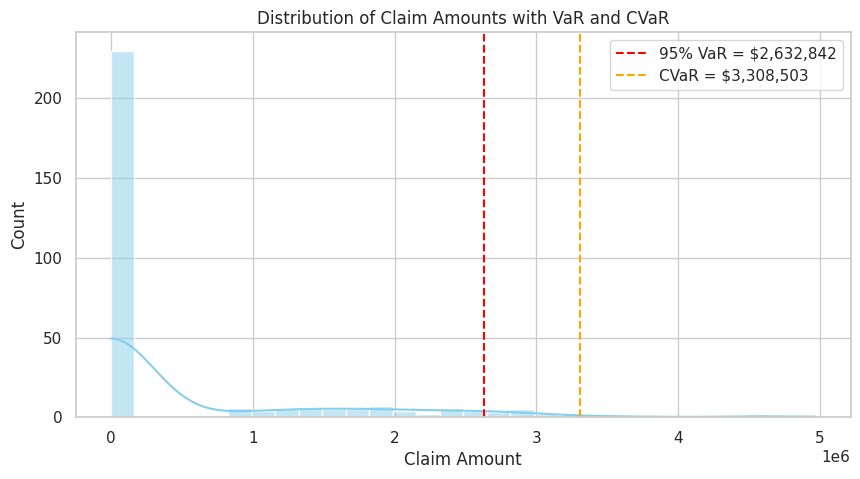

In [5]:

claim_data = df['Claim_Amount'].copy()
sorted_claims = claim_data.sort_values()

# 95% VaR
var_95 = np.percentile(sorted_claims, 95) # VaR

# CVaR: Mean of worst 5%
cvar_95 = sorted_claims[sorted_claims >= var_95].mean()

print("📉 95% Value-at-Risk (VaR): ${:,.2f}".format(var_95))
print("🔥 Conditional VaR (CVaR): ${:,.2f}".format(cvar_95))

# Plot histogram
plt.figure(figsize=(10,5))
sns.histplot(sorted_claims, bins=30, kde=True, color='skyblue')
plt.axvline(var_95, color='red', linestyle='--', label=f'95% VaR = ${var_95:,.0f}')
plt.axvline(cvar_95, color='orange', linestyle='--', label=f'CVaR = ${cvar_95:,.0f}')
plt.legend()
plt.title('Distribution of Claim Amounts with VaR and CVaR')
plt.xlabel('Claim Amount')
plt.show()


## 🧪 Exercise 2: Portfolio Simulation and Return Projection

In [6]:

portfolio_returns = df.groupby('Vessel_Type').agg(
    Total_Invested=('Initial_Investment', 'sum'),
    Final_Value=('Final_Value', 'sum'),
    Mean_Return=('Daily_Return', 'mean'),
    Std_Dev=('Daily_Return', 'std')
)

portfolio_returns['Cumulative_Return_%'] = ((portfolio_returns['Final_Value'] / portfolio_returns['Total_Invested']) - 1) * 100
portfolio_returns


,Total_Invested,Final_Value,Mean_Return,Std_Dev,Cumulative_Return_%
Vessel_Type,,,,,
Bulk Carrier,6872100.0,7.140088e+06,0.000392,0.000867,3.899648
Container Ship,8137200.0,8.636669e+06,0.000617,0.001019,6.138091
Offshore Support Vessel,1999800.0,2.089830e+06,0.000460,0.000786,4.501966
Tanker,11350800.0,1.191962e+07,0.000491,0.001100,5.011266


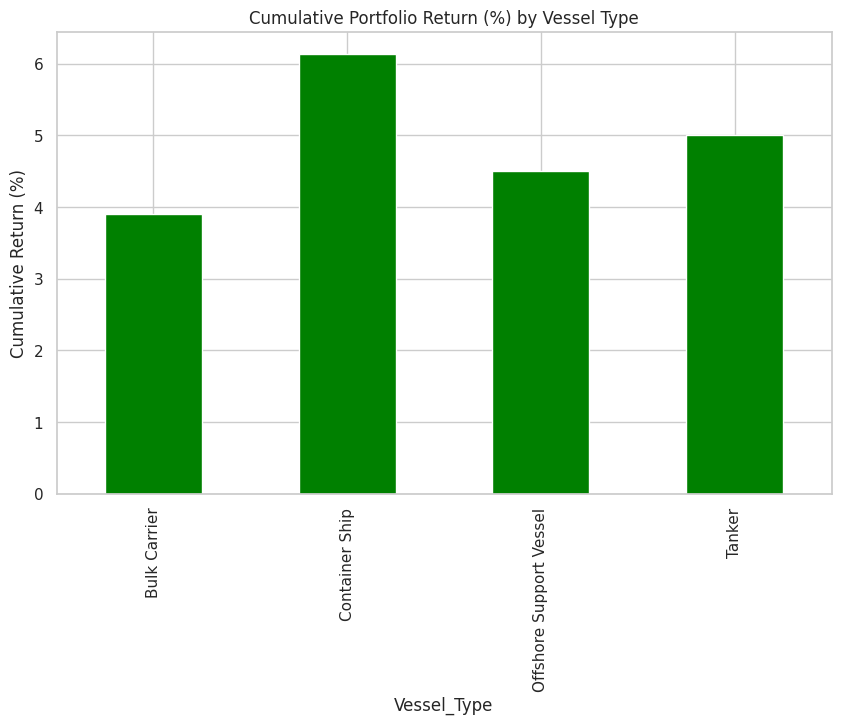

In [7]:

portfolio_returns['Cumulative_Return_%'].plot(kind='bar', figsize=(10,6), color='green', title='Cumulative Portfolio Return (%) by Vessel Type')
plt.ylabel('Cumulative Return (%)')
plt.grid(True)
plt.show()


## 🧪 Exercise 3: Mean-Variance Optimization

In [8]:
returns_df = df.groupby('Vessel_Type').agg(
    Mean_Return=('Final_Value', 'mean'),
    Std_Dev=('Final_Value', 'std')
)

returns_df

,Mean_Return,Std_Dev
Vessel_Type,,
Bulk Carrier,82069.973351,7080.560881
Container Ship,102817.484637,10126.189808
Offshore Support Vessel,69661.010328,5741.648522
Tanker,120400.189214,12339.357750


In [9]:
# Generate sample weight combinations
weights = np.linspace(0, 1, 11)
weights

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [10]:
results = []

# Try combinations of 3 assets: Tanker, Bulk Carrier, Container Ship
for w1 in weights:
    for w2 in weights:
        if w1 + w2 <= 1:
            w3 = 1 - w1 - w2
            mean_return = (w1 * returns_df.loc['Tanker', 'Mean_Return'] +
                           w2 * returns_df.loc['Bulk Carrier', 'Mean_Return'] +
                           w3 * returns_df.loc['Container Ship', 'Mean_Return'])
            std_dev = np.sqrt((w1**2 * returns_df.loc['Tanker', 'Std_Dev']**2) +
                              (w2**2 * returns_df.loc['Bulk Carrier', 'Std_Dev']**2) +
                              (w3**2 * returns_df.loc['Container Ship', 'Std_Dev']**2))
            results.append((w1, w2, w3, mean_return, std_dev))

opt_df = pd.DataFrame(results, columns=['Tanker_Weight', 'Bulk_Weight', 'Container_Weight', 'Expected_Return', 'Portfolio_Risk'])

opt_df

,Tanker_Weight,Bulk_Weight,Container_Weight,Expected_Return,Portfolio_Risk
0,0.0,0.0,1.000000e+00,102817.484637,10126.189808
1,0.0,0.1,9.000000e-01,100742.733508,9141.034769
2,0.0,0.2,8.000000e-01,98667.982379,8223.794411
3,0.0,0.3,7.000000e-01,96593.231251,7399.767134
4,0.0,0.4,6.000000e-01,94518.480122,6703.416591
...,...,...,...,...,...
61,0.8,0.1,1.000000e-01,114808.897170,9948.516494
62,0.8,0.2,-5.551115e-17,112734.146041,9972.542980
63,0.9,0.0,1.000000e-01,118641.918756,11151.492925
64,0.9,0.1,-2.775558e-17,116567.167628,11127.971094


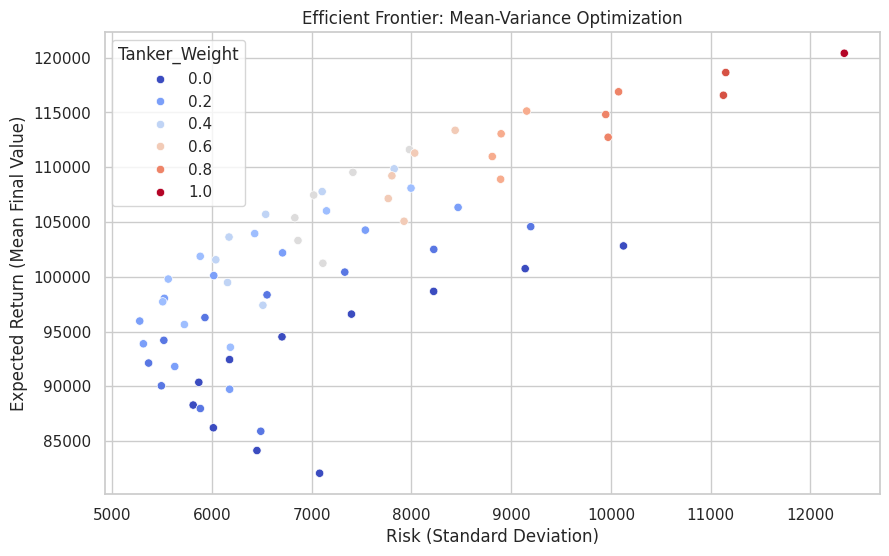

In [11]:
# Plot Efficient Frontier
plt.figure(figsize=(10,6))
sns.scatterplot(data=opt_df, x='Portfolio_Risk', y='Expected_Return', hue='Tanker_Weight', palette='coolwarm')
plt.title('Efficient Frontier: Mean-Variance Optimization')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return (Mean Final Value)')
plt.grid(True)
plt.show()


In [13]:
# always observe highest sharpe ratio,
# sharpe_ratio = [Expected_return - Rf(risk free rate) ] / Risk(std_dev)

opt_df['sharpe_ratio'] = opt_df['Expected_Return']/opt_df['Portfolio_Risk']
best_portfolio = opt_df.loc[np.argmax(opt_df['sharpe_ratio'])]

print("Best Distribution")
print(best_portfolio)

Best Distribution
Tanker_Weight           0.200000
Bulk_Weight             0.500000
Container_Weight        0.300000
Expected_Return     95960.269909
Portfolio_Risk       5277.551552
sharpe_ratio           18.182725
Name: 26, dtype: float64


In [14]:
opt_df.describe()

,Tanker_Weight,Bulk_Weight,Container_Weight,Expected_Return,Portfolio_Risk,sharpe_ratio
count,66.000000,66.000000,6.600000e+01,66.000000,66.000000,66.000000
mean,0.333333,0.333333,3.333333e-01,101762.549067,7303.624320,14.348806
std,0.270801,0.270801,2.708013e-01,8999.440335,1612.765733,2.122301
min,0.000000,0.000000,-1.110223e-16,82069.973351,5277.551552,9.757411
25%,0.100000,0.100000,1.000000e-01,95722.909406,6024.876778,12.786907
50%,0.300000,0.300000,3.000000e-01,102026.282959,6942.561145,14.428031
75%,0.500000,0.500000,5.000000e-01,108013.175842,8176.318924,16.159984
max,1.000000,1.000000,1.000000e+00,120400.189214,12339.357750,18.182725


In [16]:
opt_df['sharpe_ratio'] = (opt_df['Expected_Return']-100000)/opt_df['Portfolio_Risk']
best_portfolio = opt_df.loc[np.argmax(opt_df['sharpe_ratio'])]

print("Best Distribution")
print(best_portfolio)

Best Distribution
Tanker_Weight            0.800000
Bulk_Weight              0.000000
Container_Weight         0.200000
Expected_Return     116883.648298
Portfolio_Risk       10077.094254
sharpe_ratio             1.675448
Name: 60, dtype: float64



## 📌 Summary of Insights

- **VaR/CVaR** highlighted potential tail risk in claim distributions.
- **Portfolio Simulation** showed performance variance across vessel types.
- **Mean-Variance Optimization** offered a visual method to balance return and risk using allocation strategies.

These tools help insurers make data-driven capital allocation decisions.
